In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_adam_opt
from asteroid_search_report import traj_diff
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64
h = 1.0/64.0  # (1.5625%)
R_deg = 1.0

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# Review unperturbed elements
elts_ast

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,0.015625,0.017453
1,59244,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0,0.015625,0.017453
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,0.015625,0.017453
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0,0.015625,0.017453
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,0.015625,0.017453
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,0.015625,0.017453
60,134815,2.612770,0.140831,0.513922,0.272689,0.645552,-0.957836,58600.0,0.015625,0.017453
61,27860,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0,0.015625,0.017453
62,85937,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,0.015625,0.017453


In [10]:
# Inpute to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert = perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                         sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                         sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                         mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Review perturbed elements
elts_pert

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,0.015625,0.017453
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,0.015625,0.017453
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,0.015625,0.017453
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,0.015625,0.017453
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,0.015625,0.017453
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,0.015625,0.017453
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,0.015625,0.017453
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,0.015625,0.017453
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,0.015625,0.017453


In [12]:
# Random elements
elts_rand = random_elts(element_id_start=0, size=batch_size, h=h, R_deg=R_deg,
                        random_seed=random_seed, dtype=dtype_np)

In [13]:
# Review random elements
elts_rand

,element_id,a,e,f,inc,Omega,omega,epoch,h,R
0,0,2.346512,0.191774,3.947884,0.123224,5.077989,4.698056,58600.0,0.015625,0.017453
1,1,3.002211,0.239903,-2.104391,0.032646,3.623584,5.988327,58600.0,0.015625,0.017453
2,2,2.317087,0.055763,-4.869156,0.034794,3.476631,2.078166,58600.0,0.015625,0.017453
3,3,2.349419,0.200190,3.323487,0.222124,1.726133,3.473125,58600.0,0.015625,0.017453
4,4,2.712220,0.116107,4.183110,0.200886,0.668298,3.595820,58600.0,0.015625,0.017453
...,...,...,...,...,...,...,...,...,...,...
59,59,2.328723,0.639718,1.285795,0.064922,1.580547,4.395165,58600.0,0.015625,0.017453
60,60,3.972593,0.039944,-0.006957,0.176738,5.749878,0.869298,58600.0,0.015625,0.017453
61,61,3.019390,0.032757,-3.315554,0.115168,1.725482,0.834064,58600.0,0.015625,0.017453
62,62,2.481321,0.025182,2.025885,0.337006,2.972029,6.091780,58600.0,0.015625,0.017453


## Batches of ZTF Data vs. Elements

In [14]:
# Arguments to make_ztf_batch
# thresh_deg = 1.0
thresh_deg = 4.0
near_ast = False
regenerate = False

In [15]:
# Load unperturbed element batch
ztf_elt_ast = load_ztf_batch(elts=elts_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [16]:
# Load perturbed element batch
ztf_elt_pert = load_ztf_batch(elts=elts_pert, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [17]:
# Load random element batch
ztf_elt_rand = load_ztf_batch(elts=elts_rand, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
# Summarize the ztf element batch: unperturbed asteroids
score_by_elt_ast = ztf_elt_summary(ztf_elt_ast, 'Unperturbed Asteroids')

ZTF Element Dataframe Unperturbed Asteroids:
                  Total     (Per Batch)
Observations   :  1233691   (    19276)
Hits           :    10333   (   161.45)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :    3347.31
Sqrt(batch_obs):     138.84
Mean t_score   :      26.13


In [19]:
# score_by_elt_ast

In [20]:
# Summarize the ztf element batch: perturbed asteroids
score_by_elt_pert = ztf_elt_summary(ztf_elt_pert, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :  1148437   (    17944)
Hits           :        0   (     0.00)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     146.79
Sqrt(batch_obs):     133.96
Mean t_score   :       0.90


In [21]:
# Summarize the ztf element batch: random elements
score_by_elt_rand = ztf_elt_summary(ztf_elt_rand, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :  1056703   (    16773)
Hits           :        0   (     0.00)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      82.21
Sqrt(batch_obs):     129.51
Mean t_score   :       0.28


## View Example DataFrames and Hits

In [22]:
ztf_elt_ast

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,25248,733,b'ZTF18absqzef',611130485415015022,7576,58365.130486,269.830331,-14.496884,-0.002867,-0.987841,...,0.003988,-0.053007,-0.979529,0.194197,2.419761,0.063916,13185.789822,0.997957,0.838525,False
1,37580,733,b'ZTF18abcsqhf',618126363115010066,8913,58372.126366,271.256633,-11.466062,0.021493,-0.978028,...,0.003945,-0.042686,-0.979082,0.198938,2.501611,0.064738,13355.474480,0.997905,0.860237,False
2,37581,733,b'ZTF18abcsqhf',617209183115010025,8768,58371.209190,271.256646,-11.466037,0.021493,-0.978028,...,0.003950,-0.044314,-0.979129,0.198349,2.490799,0.066430,13704.750780,0.997794,0.905803,False
3,37582,733,b'ZTF18abcsqhf',617122523115010032,8730,58371.122523,271.256648,-11.466060,0.021493,-0.978028,...,0.003951,-0.044456,-0.979134,0.198292,2.489770,0.066579,13735.393413,0.997784,0.909857,False
4,37587,733,b'ZTF18abcsqhf',567274573115010023,3341,58321.274572,271.256647,-11.466069,0.021493,-0.978028,...,0.004191,-0.000053,-0.989617,0.143727,2.018643,0.068175,14064.801909,0.997676,0.954004,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233686,5651378,324582,b'ZTF20aaqvkyo',1150185754815015007,96635,58904.185752,42.122572,29.195466,0.647485,0.731228,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.029094,6001.222051,0.999577,0.173740,False
1233687,5651434,324582,b'ZTF20aaqvkus',1150185310315015002,96634,58904.185313,43.256211,29.954124,0.631015,0.743348,...,-0.001541,0.627610,0.750725,0.206200,2.981912,0.017707,3652.453216,0.999843,0.064359,False
1233688,5651513,324582,b'ZTF20aaqvlna',1150185755115015011,96635,58904.185752,42.388038,28.228923,0.650751,0.733102,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.030306,6251.306560,0.999541,0.188521,False
1233689,5651704,324582,b'ZTF20aaqvlmz',1150185755115015003,96635,58904.185752,41.916630,28.631276,0.653128,0.728579,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.033791,6970.130701,0.999429,0.234365,False


In [23]:
# Review hits
mask = ztf_elt_ast.is_hit
ztf_elt_ast[mask]

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
178,341737,733,b'ZTF19abizrac',937427766115015019,40797,58691.427766,33.130412,43.596186,0.606481,0.637452,...,-0.002127,0.606486,0.637448,0.475220,2.115260,0.000007,1.509138,1.0,1.098777e-08,True
191,345725,733,b'ZTF19abjajfg',937467364815015020,40840,58691.467361,33.148426,43.605278,0.606265,0.637618,...,-0.002129,0.606270,0.637614,0.475274,2.114851,0.000007,1.479386,1.0,1.055879e-08,True
196,346522,733,b'ZTF19abjajmr',937468726115015011,40842,58691.468727,33.149062,43.605587,0.606257,0.637624,...,-0.002129,0.606263,0.637619,0.475276,2.114837,0.000007,1.503609,1.0,1.090740e-08,True
205,347644,733,b'ZTF19abiyxiu',937402264815015008,40777,58691.402269,33.118785,43.590288,0.606621,0.637345,...,-0.002127,0.606626,0.637341,0.475186,2.115523,0.000007,1.491440,1.0,1.073157e-08,True
222,431445,733,b'ZTF19abkkfhr',934448315015015003,40221,58688.448310,31.751906,42.913068,0.622775,0.624451,...,-0.002040,0.622780,0.624447,0.471393,2.145603,0.000007,1.493960,1.0,1.076786e-08,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233374,5447574,324582,b'ZTF20aapdfmj',1145121244815015014,95204,58899.121250,42.392273,29.202629,0.644677,0.734024,...,-0.001502,0.644680,0.734021,0.213544,2.915471,0.000005,0.934688,1.0,4.214873e-09,True
1233417,5450145,324582,b'ZTF20aapdfmj',1145121716115015016,95205,58899.121713,42.392439,29.202638,0.644675,0.734026,...,-0.001502,0.644678,0.734022,0.213543,2.915477,0.000005,1.005771,1.0,4.880340e-09,True
1233479,5461311,324582,b'ZTF20aapeobw',1145164884815015018,95284,58899.164884,42.405891,29.202386,0.644538,0.734164,...,-0.001503,0.644541,0.734161,0.213479,2.916052,0.000004,0.890844,1.0,3.828730e-09,True
1233480,5461312,324582,b'ZTF20aapeobw',1145165336115015009,95285,58899.165336,42.406082,29.202412,0.644536,0.734166,...,-0.001503,0.644540,0.734163,0.213478,2.916058,0.000005,1.056357,1.0,5.383601e-09,True


In [24]:
ztf_elt_ast.columns

Index(['ztf_id', 'element_id', 'ObjectID', 'CandidateID', 'TimeStampID', 'mjd',
       'ra', 'dec', 'ux', 'uy', 'uz', 'qx', 'qy', 'qz', 'vx', 'vy', 'vz',
       'elt_ux', 'elt_uy', 'elt_uz', 'elt_r', 's', 's_sec', 'z', 'v',
       'is_hit'],
      dtype='object')

In [25]:
# Alias ztf_elt_ast to ztf_elt
ztf_elt = ztf_elt_ast

In [26]:
# Build numpy array of times
ts_np = ztf_elt.mjd.values.astype(dtype_np)

# Get observation count per element
row_lengths_np = ztf_elt.element_id.groupby(ztf_elt.element_id).count().values.astype(np.int32)

In [27]:
# Review results
element_id_best = ast_num_best[0]
mask = (ztf_elt.element_id == element_id_best)
hits_best = np.sum(ztf_elt[mask].is_hit)
hit_rate_best = np.mean(ztf_elt[mask].is_hit)
rows_best = np.sum(mask)
s_sec_min = np.min(ztf_elt[mask].s_sec)
idx = np.argmin(ztf_elt.s)
ztf_id = ztf_elt.ztf_id[idx]
# ztf_elt[mask].iloc[idx:idx+1]
print(f'Best asteroid has element_id = {element_id_best}')
print(f'Hit count: {hits_best} / {rows_best} observations')
print(f'Hit rate : {hit_rate_best:8.6f}')
print(f'Closest hit: {s_sec_min:0.3f} arc seconds')
# ztf_elt[mask]

Best asteroid has element_id = 51921
Hit count: 158 / 10110 observations
Hit rate : 0.015628
Closest hit: 0.381 arc seconds


## Build Asteroid Search Model

In [28]:
# Additional arguments for asteroid search models
site_name = 'palomar'

# Training parameters
learning_rate = 2.0**-13 # (1.22E-4)
clipnorm = 1.0
regenerate = False

In [29]:
# Adaptive search parameters - tiny size
max_batches = 1000
batches_per_epoch = 10
epochs_per_episode = 5
min_learning_rate = 2.0**-20 # about 9.54E-7
verbose = 1

In [30]:
# Review candidate elements
elts_ast

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,0.015625,0.017453
1,59244,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0,0.015625,0.017453
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,0.015625,0.017453
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0,0.015625,0.017453
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,0.015625,0.017453
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,0.015625,0.017453
60,134815,2.612770,0.140831,0.513922,0.272689,0.645552,-0.957836,58600.0,0.015625,0.017453
61,27860,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0,0.015625,0.017453
62,85937,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,0.015625,0.017453


In [31]:
# Build asteroid search model
model = AsteroidSearchModel(
        elts=elts_ast, ztf_elt=ztf_elt, 
        site_name=site_name, thresh_deg=thresh_deg, 
        learning_rate=learning_rate, clipnorm=clipnorm)

In [32]:
# Train unperturbed model
model.search_adaptive(
    max_batches=max_batches, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    regenerate=False,
    verbose=verbose)

Loaded candidate elements and training history from ../data/candidate_elt/candidate_elt_6490016596481062962.h5.
Train on 640 samples
Geom Mean Resolution: 0.342244 degrees
Mean Log Likelihood:    500.82

********************************************************************************
Terminating: Reached final batch 1000.
********************************************************************************
Saving candidate elements DataFrame in ../data/candidate_elt/candidate_elt_6490016596481062962.h5.


In [33]:
# Dummy inputs for search model; any array with shape [batch_size,] is good
x = tf.ones(batch_size)

In [34]:
# Run model on unperturbed elements
log_like, orbital_elements, mixture_parameters = model(x)

In [35]:
# Summarize log likelihood on unperturbed elements
log_like_mean = np.mean(log_like)
log_like_std = np.std(log_like)
log_like_min = np.min(log_like)
log_like_max = np.max(log_like)

# Report on unperturbed elements
print(f'Log likelihood:')
print(f'Mean: {log_like_mean:8.2f}')
print(f'Std : {log_like_std:8.2f}')
print(f'Min : {log_like_min:8.2f}')
print(f'Max : {log_like_max:8.2f}')

Log likelihood:
Mean:   500.82
Std :   346.49
Min :    29.80
Max :  1615.52


In [36]:
# Fit one batch
hist = model.fit(x)

Train on 64 samples
64/64 [==============================] - 3s 41ms/sample - loss: -498.0488


In [37]:
# Evaluate
model.evaluate(x)

64/64 [==============================] - 0s 1ms/sample - loss: -1.2062


-1.2062060236930847

In [38]:
# Built in log likelihood caclulation
# model.calc_log_like()

In [39]:
# Visualize model summary - layers and parameters
model.summary()

Model: "asteroid_search_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
direction (AsteroidDirection multiple                  7402146   
_________________________________________________________________
score (TrajectoryScore)      multiple                  0         
_________________________________________________________________
model_asteroid_pos (Model)   ((64, None, 3), (64, None 7402146   
_________________________________________________________________
candidate_elements (Candidat multiple                  576       
Total params: 14,804,868
Trainable params: 512
Non-trainable params: 14,804,356
_________________________________________________________________


In [40]:
# model.train_hist_summary.columns

In [41]:
# model.plot_log_like()

In [42]:
# model.train_hist_summary

In [43]:
# model.candidates_df()

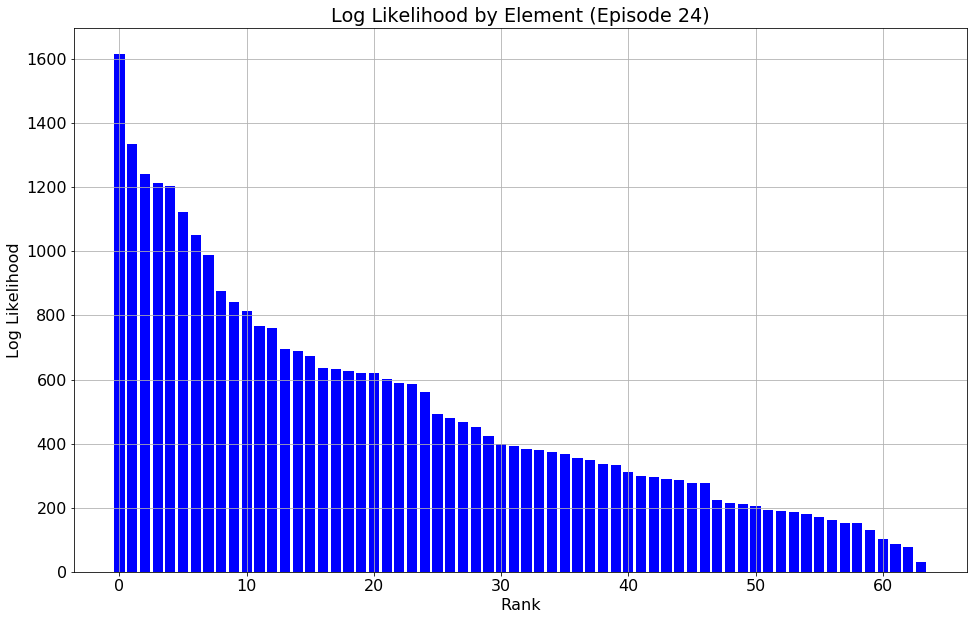

In [44]:
model.plot_log_like_bar()

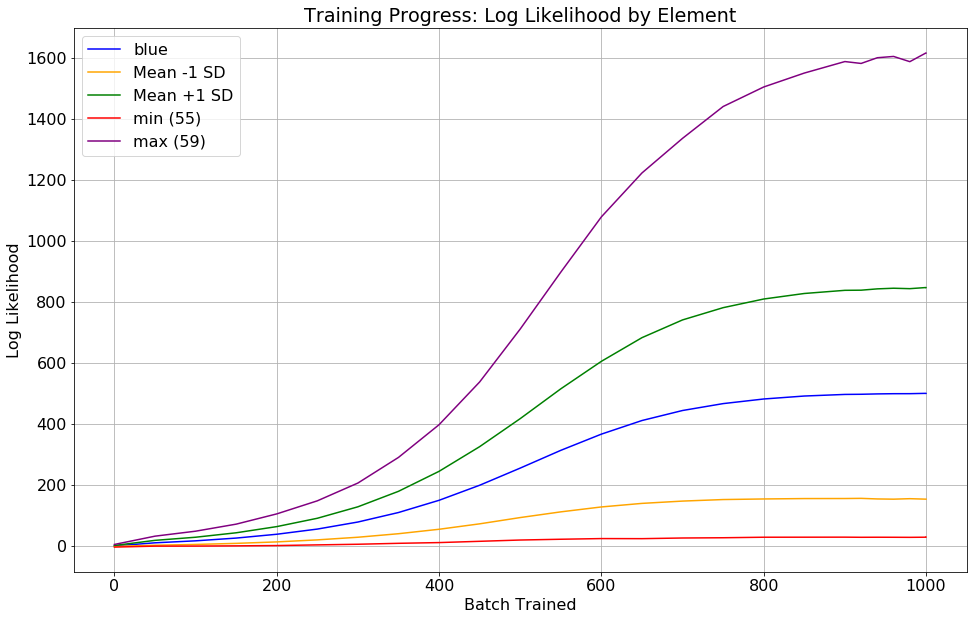

In [45]:
model.plot_log_like()

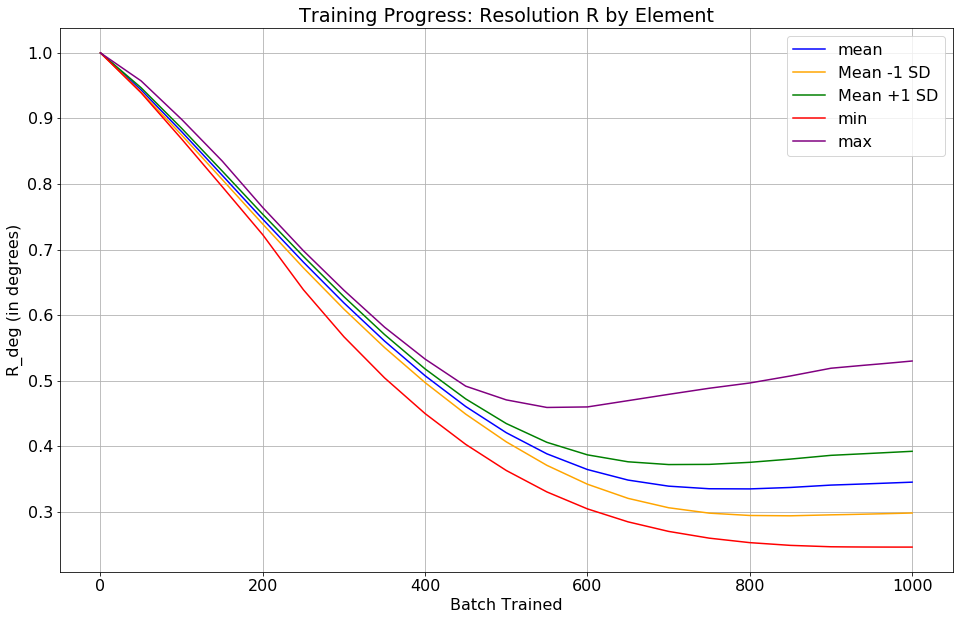

In [46]:
model.plot_R_deg()

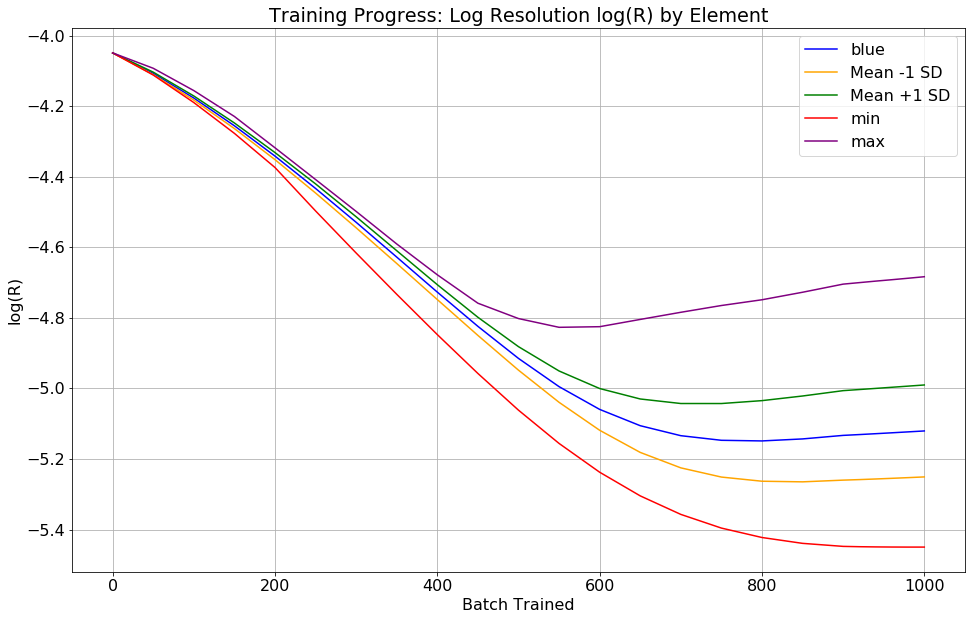

In [47]:
model.plot_log_R()

In [48]:
# hist_err = model.calc_error(elts_ast)
# hist_err

,key,element_num,element_id,episode,epoch,batch,training_time,log_like,a,e,...,e_err,e_log_err,inc_err,inc_log_err,Omega_err,Omega_log_err,omega_err,omega_log_err,f_err,f_log_err
0,0,0,51921,0,0,0,0.000000,2.016980,2.669305,0.217361,...,5.532608e-09,-19.012607,1.070252e-07,-16.050202,1.872297e-07,-15.490930,3.136735e-08,-17.277498,4.076807e-08,-17.015367
1,1,1,59244,0,0,0,0.000000,1.491612,2.634727,0.262503,...,7.003021e-10,-21.079509,9.830823e-08,-16.135158,6.650086e-08,-16.526051,5.649156e-08,-16.689175,5.392809e-08,-16.735614
2,2,2,15786,0,0,0,0.000000,0.680310,1.883227,0.047655,...,2.987289e-10,-21.931484,5.611059e-08,-16.695941,1.272933e-07,-15.876772,4.952550e-08,-16.820778,4.435845e-08,-16.930963
3,3,3,3904,0,0,0,0.000000,0.821385,2.556387,0.098279,...,8.896446e-10,-20.840199,1.088912e-08,-18.335502,1.550414e-07,-15.679573,3.340689e-08,-17.214504,3.837030e-09,-19.378567
4,4,4,142999,0,0,0,0.000000,0.228261,2.619944,0.191376,...,9.386444e-10,-20.786584,7.645042e-08,-16.386623,6.893959e-09,-18.792620,3.145281e-08,-17.274777,2.308686e-08,-17.584002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1595,59,11952,24,100,1000,71.564008,1615.515015,2.188790,0.013403,...,7.268778e-02,-2.621582,1.836285e-02,-3.997426,3.689217e-02,-3.299756,1.315150e-01,-2.028634,2.829680e-02,-3.565007
1596,1596,60,134815,24,100,1000,71.564008,205.257111,2.613940,0.171582,...,3.075091e-02,-3.481836,3.186422e-03,-5.748857,8.892343e-03,-4.722565,2.285271e-02,-3.778686,4.597122e-02,-3.079740
1597,1597,61,27860,24,100,1000,71.564008,560.178589,2.482259,0.159936,...,6.375116e-02,-2.752768,1.217645e-02,-4.408252,8.546174e-02,-2.459686,4.930599e-02,-3.009710,8.613261e-03,-4.754452
1598,1598,62,85937,24,100,1000,71.564008,153.818390,2.456120,0.135784,...,6.148305e-02,-2.788994,1.704820e-02,-4.071711,7.393528e-02,-2.604565,8.749221e-03,-4.738791,1.024078e-01,-2.278793


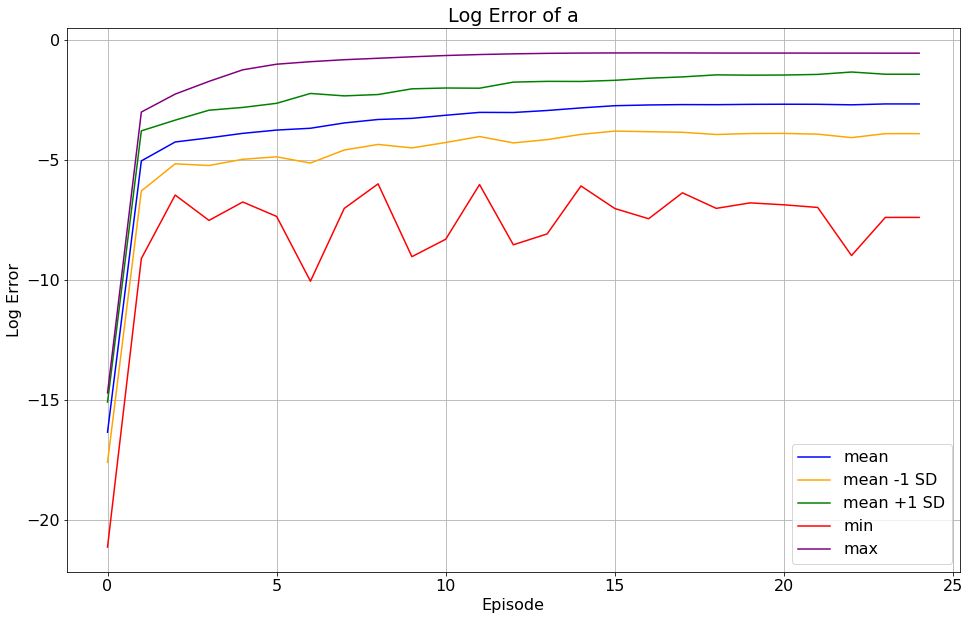

In [49]:
# Plot error in orbital elements
model.plot_elt_error(elts_true=elts_ast, elt_name='a', is_log=True, elt_num=None)

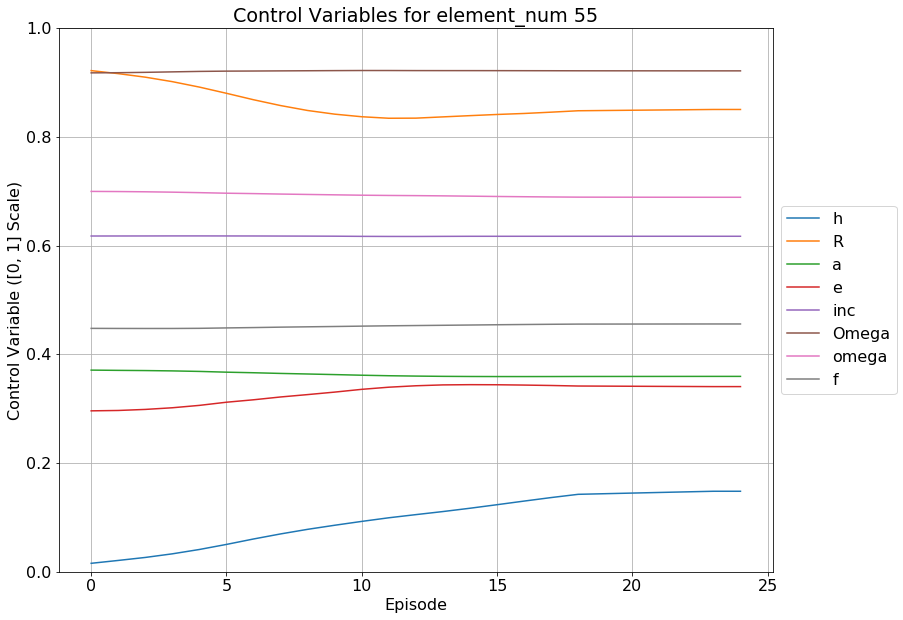

In [50]:
# Plot control variables for worst element
model.plot_control(element_num=55)

In [51]:
# prototype plot_control
element_num = 55

hist = model.train_hist_elt
mask = (hist.element_num == element_num)
hist = hist[mask]
hist

,key,element_num,element_id,episode,epoch,batch,training_time,log_like,a,e,...,R_sec,log_R,a_,e_,inc_,Omega_,omega_,f_,h_,R_
55,55,55,18181,0,0,0,0.000000,0.245849,2.339357,0.296092,...,3600.001221,-4.048239,0.371019,0.296092,0.617707,0.917837,0.699762,0.447812,0.015625,0.921963
119,119,55,18181,1,5,50,8.326068,0.531337,2.334876,0.296777,...,3426.987305,-4.097491,0.370558,0.296777,0.617758,0.918123,0.699510,0.447664,0.020897,0.916418
183,183,55,18181,2,10,100,11.377333,0.771087,2.331375,0.298709,...,3234.999268,-4.155142,0.370197,0.298709,0.617800,0.918801,0.699066,0.447600,0.026402,0.909927
247,247,55,18181,3,15,150,14.470535,1.419377,2.325338,0.301756,...,3006.138428,-4.228513,0.369573,0.301756,0.617882,0.919666,0.698375,0.447619,0.033051,0.901666
311,311,55,18181,4,20,200,17.779138,2.423066,2.316114,0.306147,...,2750.601807,-4.317348,0.368618,0.306147,0.617887,0.920512,0.697482,0.447897,0.041051,0.891664
375,375,55,18181,5,25,250,20.901099,4.608292,2.302830,0.311948,...,2485.602783,-4.418652,0.367235,0.311948,0.617818,0.921031,0.696451,0.448637,0.050362,0.880258
439,439,55,18181,6,30,300,24.064675,6.698214,2.292773,0.316437,...,2237.237549,-4.523924,0.366182,0.316437,0.617770,0.921223,0.695738,0.449282,0.060353,0.868406
503,503,55,18181,7,35,350,27.178472,9.767775,2.280822,0.321603,...,2034.218872,-4.619053,0.364926,0.321603,0.617640,0.921490,0.694884,0.450060,0.069657,0.857695
567,567,55,18181,8,40,400,30.209648,12.159306,2.270903,0.325982,...,1876.776001,-4.699609,0.363878,0.325982,0.617522,0.921726,0.694170,0.450671,0.078116,0.848625
631,631,55,18181,9,45,450,33.286800,16.324411,2.260616,0.330562,...,1767.696289,-4.759487,0.362786,0.330562,0.617372,0.921973,0.693470,0.451256,0.085619,0.841884


In [52]:
hist.a_.shape

(25,)

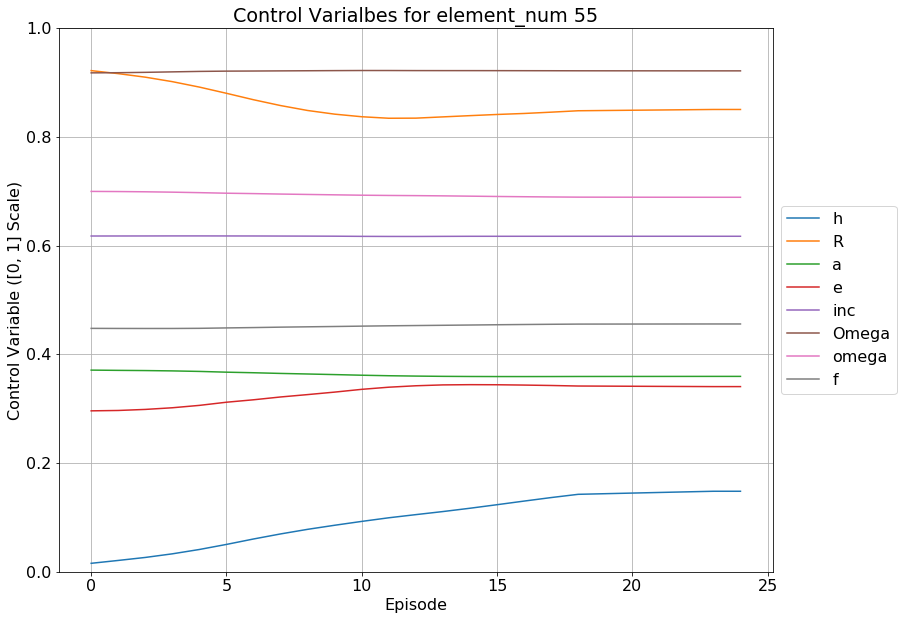

In [53]:
# Plot control variables
fig, ax = plt.subplots()
ax.set_title(f'Control Varialbes for element_num {element_num}')
ax.set_xlabel('Episode')
ax.set_ylabel('Control Variable ([0, 1] Scale)')
# Plot mixture parameters
ax.plot(hist.episode, hist.h_, label='h')
ax.plot(hist.episode, hist.R_, label='R')
# Plot elements
ax.plot(hist.episode, hist.a_, label='a')
ax.plot(hist.episode, hist.e_, label='e')
ax.plot(hist.episode, hist.inc_, label='inc')
ax.plot(hist.episode, hist.Omega_, label='Omega')
ax.plot(hist.episode, hist.omega_, label='omega')
ax.plot(hist.episode, hist.f_, label='f')
# Legend, scale etc
ax.set_ylim([0, 1])
ax.grid()
# Put legend to the right of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig.savefig('../figs/training/control_var_deg.png', bbox_inches='tight')
plt.show()

In [54]:
# raise ValueError

## Fit Model on Unperturbed Elements

In [55]:
# Training parameters
learning_rate = 2.0**-13 # (1.22E-4)
clipnorm = 1.0
regenerate = False

In [56]:
# Adaptive search parameters
max_batches = 20000
batches_per_epoch = 100
epochs_per_episode = 5
min_learning_rate = 2.0**-20 # about 9.54E-7
verbose = 1

In [ ]:
# Build asteroid search model
model_ast = AsteroidSearchModel(
                elts=elts_ast, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm)

In [ ]:
# Tiny size for fast testing
max_batches = 1000
batches_per_epoch = 10

In [ ]:
# alias model_ast to model for interactive testing
model = model_ast

In [ ]:
# # Regenerate elements from model
# elts_df = model.load_candidates(verbose=True)

In [ ]:
# Report elements from model
elts_df = model.candidates_df()

# Review regenerated elements and scores
elts_df

In [ ]:
# Train unperturbed model
model_ast.search_adaptive(
    max_batches=max_batches, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    regenerate=True,
    verbose=verbose)

In [ ]:
model.train_hist_summary

In [ ]:
# model.review_members()

In [ ]:
# # Second (tune-up) adaptive training
# model.search_adaptive(
#     max_batches=max_batches, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     min_learning_rate=min_learning_rate,
#     regenerate=True,
#     verbose=verbose)

In [ ]:
# Review likelihoods by element
log_like_ast, orbital_elements_ast, mixture_parameters_ast = model_ast.calc_outputs()

In [ ]:
log_like_ast

In [ ]:
# Review resolution in arc seconds
dist2deg(mixture_parameters_ast[2])

In [ ]:
elts_fit = model_ast.candidates_df()
elts_fit

In [ ]:
np.median(elts_fit.R_deg)

In [ ]:
model_pos = make_model_ast_pos(ts_np=ztf_elt.mjd, row_lengths_np=row_lengths_np)

In [ ]:
traj_err = traj_diff(elts_ast, elts_fit, model_pos)
traj_err

In [ ]:
np.exp(np.mean(np.log(traj_err)))

In [ ]:
np.median(traj_err)

In [ ]:
# plot log_like

## Train on Perturbed Elements

In [ ]:
# Build asteroid search model
model_pert = AsteroidSearchModel(
                 elts=elts_pert, ztf_elt=ztf_elt_pert, site_name=site_name,
                 thresh_deg=thresh_deg, h=h, R_deg=R_deg,
                 learning_rate=learning_rate, clipnorm=clipnorm)

In [ ]:
# Train model on perturbed elements
model_pert.search_adaptive(
    max_batches=max_batches, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    regenerate=regenerate,
    verbose=verbose)

In [ ]:
# Review likelihoods by element
log_like_per, orbital_elements_pert, mixture_parameters_pert = model_pert.calc_outputs()

In [ ]:
log_like_pert

## Train on Random Elements

In [ ]:
# Filter elts_rand down to only those that had matching ztf observations
idx = np.unique(ztf_elt_rand.element_id)
elts_rand = elts_rand.loc[idx]

In [ ]:
elts_rand['a'].dtype

In [ ]:
elts_rand['a'].dtype

In [ ]:
for col in ['a', 'e', 'f', 'inc', 'Omega', 'omega', 'epoch']:
    elts_rand[col] = elts_rand[col].astype(np.float32)

In [ ]:
# Build asteroid search model
model_rand = AsteroidSearchModel(
                 elts=elts_rand, ztf_elt=ztf_elt_rand, site_name=site_name,
                 thresh_deg=thresh_deg, h=h, R_deg=R_deg,
                 learning_rate=learning_rate, clipnorm=clipnorm)

In [ ]:
# Train model on perturbed elements
model_rand.search_adaptive(
    max_batches=max_batches, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    verbose=verbose)

In [ ]:
# Review likelihoods by element
log_like_rand, orbital_elements_rand, mixture_parameters_rand = model_rand.calc_outputs()

In [ ]:
log_like_rand

In [ ]:
# orbital_elements_rand